# Symmer VQE Qiskit Runtime program

The way in which one should interface with IBM's quantum processing units (QPUs) is via **Qiskit Runtime** programs. This allows one to fully occupy a QPU's resource for the duration of the program, instead of returning to the back of the queue for *every single circuit run*. For an algorithm such as VQE, in which *many* calls to the QPU are made, this is crucial and accelerates wall-time by several orders of magnitude.

Here, we present some basic usage of our VQE implementation within **Symmer** and how one submits jobs to remote IBM backends - including **real quantum devices**! We shall demostrate the algorithm in combination with Qubit Tapering and Contextual Subspace VQE applied to a chosen molecular system.

The ``symmer.vqe_runtime.VQE_Runtime`` class lies at the core of the ``symmer-vqe-Ve6OdoVd8X`` runtime program, whereas ``symmer.vqe_runtime.main`` is the entry-point into the program; this function must cohere to Qiskit's conventions, namely its first two arguments are ``backend`` and ``user_messenger``.

Note that VQE_Runtime not only supports standard VQE, but also contains an implementation of [qubit-ADAPT-VQE](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.020310). This allows one to leverage otherwise unwieldy problem-specific ansatze such as unitary coupled-cluster (UCC) and yield an ansatz of considerably shallower depth via a gradient-based argument.

# Building our molecule

In [1]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'HCl_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

HCl_STO-3G_SINGLET
Molecule geometry:
Cl	0.0	0.0	0.07452
H	0.0	0.0	-1.266846

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -455.1354456708125
MP2 energy:  -455.1497064364204
CCSD energy: -455.157066827179
FCI energy:  -455.1570667931492


Number of qubits: 20


# Qubit Tapering
Next, we [taper](https://arxiv.org/abs/1701.08213) our molecule to reduce the number of qubits required. This is achieved by identifying symmetries (globally commuting Pauli operators), each of which may be mapped to a single qubit and projected out of the problem. 

In [2]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.UCC_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 20 -> 17 qubits

The following stabilizers were identified:

-1 ZIZIZIIZIZZIZIIZIZZI 
-1 IZIZIZIZIZIZIZIZIZIZ 
 1 IIIIIIZZZZIIIIZZZZII


# Further CS-VQE reduction
Qubit tapering is exact, in that it perfectly preserves the energy spectrum of the original Hamiltonian. [Contextual Subspace VQE](https://quantum-journal.org/papers/q-2021-05-14-456/) (CS-VQE) on the other hand is approximate, since it enforces pseudo-symmetries whereas those in tapering are physical. Despite this, if one constructs these artificial symmetries carefully then *enough* information may be retained such that high-precision simulations are still feasible. In fact, it has been demonstrated that chemical accuracy can be achieved at a dramatic reduction in qubit resource through a combination of Qubit Tapering + CS-VQE.

The biggest strength of CS-VQE is that any number of qubits may be specified to yield a contextual subspace Hamiltonian of that size, meaning it is fully-tailorable to the available quantum device. Below, ``symmer.projection.cs_vqe.CS_VQE`` builds the CS-VQE model, whereas ``symmer.projection.stabilizers.StabilizerIdentification`` tries to find optimal pseudo-symmetries.

In [3]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)

One observes that it is possible to achieve chemical accuracy (1.6mHa) at a reduction in qubit number:

In [4]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)
error = gs_energy - molecule.fci_energy

print(gs_psi)
print()
print(f'Contextual subspace ground state error = {error}')
print(f'Achieves chemical accuracy? {error < 0.0016}')

 0.1172488490+0.0000000000j |001> +
-0.0000000000+0.0000000000j |010> +
-0.0322424104+0.0000000000j |011> +
 0.0000000000+0.0000000000j |100> +
 0.0322424104+0.0000000000j |101> +
 0.9917150877+0.0000000000j |110> +
 0.0259758770+0.0000000000j |111>

Contextual subspace ground state error = 0.0008373802868391067
Achieves chemical accuracy? True


# VQE using ``symmer-vqe-Ve6OdoVd8X`` runtime program

First things first, we need to connect to the IBMQ service. The first time this is run, you will need to provide an IBMQ token in order to access your account.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

One can monitor the hardware that is available via their service provider:

In [6]:
for name in service.backends():
    print(f'Backend name: {name.name: <29} | '+
          f'Number of qubits: {name.num_qubits: <4} | '+
          f'Number of jobs queued: {name.status().pending_jobs}'
    )

Backend name: ibmq_qasm_simulator           | Number of qubits: 32   | Number of jobs queued: 5
Backend name: ibmq_lima                     | Number of qubits: 5    | Number of jobs queued: 26
Backend name: ibmq_belem                    | Number of qubits: 5    | Number of jobs queued: 30
Backend name: ibmq_quito                    | Number of qubits: 5    | Number of jobs queued: 29
Backend name: simulator_statevector         | Number of qubits: 32   | Number of jobs queued: 4
Backend name: simulator_mps                 | Number of qubits: 100  | Number of jobs queued: 4
Backend name: simulator_extended_stabilizer | Number of qubits: 63   | Number of jobs queued: 6
Backend name: simulator_stabilizer          | Number of qubits: 5000 | Number of jobs queued: 6
Backend name: ibmq_manila                   | Number of qubits: 5    | Number of jobs queued: 215
Backend name: ibm_nairobi                   | Number of qubits: 7    | Number of jobs queued: 87
Backend name: ibm_oslo            

We will specify the Symmer VQE runtime program by its program_id:

In [7]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'

In [8]:
#service.update_program(program_id=program_id, data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
# service.delete_program(program_id) # to delete program

In [9]:
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


Before we can submit a Symmer VQE job, we must decompose the Hamiltonian into qubit-wise commuting sets. Such sets are simultaneously measureable and therefore reduces the number of quantum measurements required to evaluate the expectation value of our Hamiltonian.

In [10]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

The next ingredient is the all-important ansatz. This is the parametrized quantum state over which we optimize throughout VQE. The choice of ansatz can restrict the permitted region of Hilbert space, hence it is important that in designing an ansatz one ensures the true ground state is contained within its image.

First we'll try a *hardware efficient* ansatz; these are designed to access the largest possible region of Hilbert space for the fewest number of native gates. However, they come with some limitations. Since there is no problem-specific knowledge 'baked' into these hardware efficient ansatze, they suffer from barren plateaus - exponentially vast planes in the optimization landscape with vanishingly small gradients in every direction. For this reason, it is unlikely that one will obtain the ground state energy by sheer luck - a nudge in the right direction is usually required, otherwise known as a *warm-start*. 

In [11]:
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, insert_barriers=True)
ansatz.decompose().draw()

┌──────────┐┌──────────┐ ░ ┌───┐           ░ ┌──────────┐ ┌──────────┐ ░ »
q_0: ┤ Rx(θ[0]) ├┤ Ry(θ[3]) ├─░─┤ X ├──■────────░─┤ Rx(θ[6]) ├─┤ Ry(θ[9]) ├─░─»
     ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐      ░ ├──────────┤┌┴──────────┤ ░ »
q_1: ┤ Rx(θ[1]) ├┤ Ry(θ[4]) ├─░───┼──┤ X ├──■───░─┤ Rx(θ[7]) ├┤ Ry(θ[10]) ├─░─»
     ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐ ░ ├──────────┤├───────────┤ ░ »
q_2: ┤ Rx(θ[2]) ├┤ Ry(θ[5]) ├─░───■───────┤ X ├─░─┤ Rx(θ[8]) ├┤ Ry(θ[11]) ├─░─»
     └──────────┘└──────────┘ ░           └───┘ ░ └──────────┘└───────────┘ ░ »
«     ┌───┐           ░ ┌───────────┐┌───────────┐
«q_0: ┤ X ├──■────────░─┤ Rx(θ[12]) ├┤ Ry(θ[15]) ├
«     └─┬─┘┌─┴─┐      ░ ├───────────┤├───────────┤
«q_1: ──┼──┤ X ├──■───░─┤ Rx(θ[13]) ├┤ Ry(θ[16]) ├
«       │  └───┘┌─┴─┐ ░ ├───────────┤├───────────┤
«q_2: ──■───────┤ X ├─░─┤ Rx(θ[14]) ├┤ Ry(θ[17]) ├
«               └───┘ ░ └───────────┘└───────────┘

In [12]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    #observable
        "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    # standard VQE
        "ansatz_circuit": ansatz,
        "init_params": np.zeros(ansatz.num_parameters),
    # optimizer settings
        "optimizer": 'SLSQP',
        "opt_setting": {"maxiter":10, "gtol": 1e-6},
    # expectation value estimation options
        "n_shots": 2**10, # 18 < np.log2(0.0016**-2) < 19
        "n_realize":3,
        "mitigate_errors": True
}

job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [13]:
service.backend(backend_name).status()

In [26]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
print(job.error_message())
job.interim_results()

Job ID: cb4aqp3shjg0cvohlsg0
Job status: JobStatus.RUNNING
None


['VQE complete',
 'Optimization step #19: gradient norm = 0.29041243263812055',
 'Optimization step #19: energy = -455.1365785929241',
 'Optimization step #18: energy = -455.10222887736137',
 'Optimization step #17: gradient norm = 0.58175282504275',
 'Optimization step #17: energy = -455.11697156709243',
 'Optimization step #16: gradient norm = 0.7512135757480339',
 'Optimization step #16: energy = -455.07023166305584',
 'Optimization step #15: energy = -454.9320958288807',
 'Optimization step #14: gradient norm = 1.144131361651717',
 'Optimization step #14: energy = -454.9617487257489',
 'Optimization step #13: energy = -454.7495882340134',
 'Optimization step #12: gradient norm = 1.499505982861431',
 'Optimization step #12: energy = -454.7873819495007',
 'Optimization step #11: energy = -454.0008618945296',
 'Optimization step #10: gradient norm = 2.0744251909587135',
 'Optimization step #10: energy = -454.50385986092607',
 'Optimization step #9: energy = -453.0377953996162',
 'Opti

In [28]:
vqe_result, interim_values = job.result()

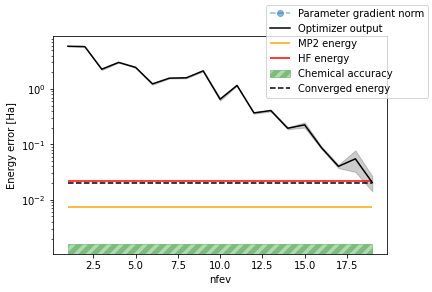

In [32]:
from matplotlib import pyplot as plt

plt.rc('hatch', color='k', linewidth=5)
fig, axis = plt.subplots()

X,Y_stddev = zip(*interim_values['stddev'])
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.fill_between(X, -0.0016, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')

Y_error = abs(Y - molecule.fci_energy)
axis.plot(X, Y_error, color='black', label='Optimizer output')
axis.hlines(vqe_result['fun'] - molecule.fci_energy, 1, len(X), color='black', label='Converged energy', ls='--')
axis.fill_between(X, Y_error - Y_stddev, Y_error + Y_stddev, alpha=0.2, color='black')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
#axis.set_ylim([np.min(Y_error)*2,(molecule.hf_energy-molecule.fci_energy)*2])
axis.set_yscale('log')

fig.legend()
plt.show()

# Now let's try running ADAPT-VQE over the UCCSD pool

We must project the UCC operator into the contextual subspace - note that it is able to achieve the same energy error as was obtained by direct diagonalization of the Hamiltonian.

In [33]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

#ucc_trunc = ucc_cs#.sort()[:40]
#anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
vqe_result[0]['fun'] - molecule.fci_energy

0.0008382295010846974

In [34]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))

In [35]:
from qiskit.quantum_info import Statevector
from symmer.symplectic import QuantumState

qc = ansatz.bind_parameters(opt_params)
psi = Statevector.from_instruction(qc).to_dict()
state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
state_matrix = np.array(state_matrix)
coeff_vec = np.array(coeff_vec)

psi = QuantumState(state_matrix, coeff_vec)
psi.conjugate * ham_cs * psi - molecule.fci_energy

(0.0008393424308792419+7.892460912098893e-31j)

In [143]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    #observable
        "observable": ham_cs.to_PauliSumOp,
        "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    # standard VQE
        #"ansatz_circuit": ansatz,
        #"init_params": np.zeros(ansatz.num_parameters),
    # ADAPT-VQE
        "adapt_flag": True,
        "ansatz_pool":[P for P in anz_cs.to_PauliSumOp],
        "adapt_max_cycles":10,
        "adapt_termination_threshold":0.0016,
        "reference_state": ref_cs,
        "reference_energy": molecule.fci_energy,
    # optimizer settings
        "optimizer": 'CG',
        "opt_setting": {"maxiter":10, "gtol": 1e-6},
    # expectation value estimation options
        "n_shots": 2**16, # 18 < np.log2(0.0016**-2) < 19
        "n_realize":1,
        "mitigate_errors": True
}

In [144]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [147]:
#job = service.job('cb4b1nrshjg0cvohmuog')
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
print(job.error_message())
service.backend(backend_name).status()

Job ID: cb4b1nrshjg0cvohmuog
Job status: JobStatus.RUNNING
None


In [176]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-455.1354456708125 -455.1570667931492


['ADAPT-VQE terminated.',
 'ADAPT cycle 4 value = -0.0002030766486882385',
 'VQE optimal params = [-0.02055484 -0.03231923 -0.03104626 -0.11885164]',
 'VQE optimal energy = -455.1572698697979',
 'VQE complete',
 'Optimization step #35: energy = -455.1569504410411',
 'Optimization step #34: energy = -455.15761024810297',
 'Optimization step #33: energy = -455.15740587598395',
 'Optimization step #32: energy = -455.15793764779323',
 'Optimization step #31: energy = -455.1566369617798',
 'Optimization step #30: energy = -455.15562809353577',
 'Optimization step #29: energy = -455.1565628682354',
 'Optimization step #28: energy = -455.15772806833917',
 'Optimization step #27: energy = -455.15690909200913',
 'Optimization step #26: energy = -455.15749577260306',
 'Optimization step #25: gradient norm = 0.025234364173008974',
 'Optimization step #25: energy = -455.1581158481405',
 'Optimization step #24: energy = -455.15539215309065',
 'Optimization step #23: gradient norm = 0.01448599482265

In [177]:
adapt_vqe_result, adapt_vqe_interim_data = job.result()
adapt_vqe_result

{'optimal_energy': -455.1572698697979,
 'optimal_params': array([-0.02055484, -0.03231923, -0.03104626, -0.11885164]),
 'optimal_pool_indices': [12, 0, 10, 7],
 'optimal_pool_labels': ['XXY', 'IIY', 'YIX', 'ZYX']}

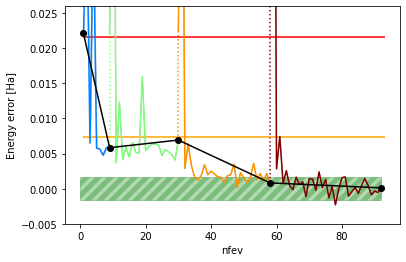

In [178]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
plt.rc('hatch', color='k', linewidth=5)

X_shift = 0
n_cycles = len(adapt_vqe_interim_data)
prev_best = None
X_over = []
Y_over = []
    
for index in range(1, n_cycles+1):
    adapt_data = adapt_vqe_interim_data[str(index)]
    c = plt.cm.jet(index/n_cycles)
    converged_value = adapt_data['vqe_result']['fun']
    interim_results = adapt_data['interim_results']
    
    X,Y_stddev = zip(*interim_results['stddev'])
    Y_stddev = Y_stddev
    X,Y = zip(*interim_results['values'])
    X,Y = np.array(X)+X_shift, np.array(Y)

    Y_error = Y - molecule.fci_energy
    axis.plot(X, Y_error, color=c, label='Optimizer output')
    plt.fill_between(X, Y_error - Y_stddev, Y_error + Y_stddev, alpha=0.2, color='black')
    
    if prev_best is not None:
        plt.vlines(X_shift+1, Y_error[0], prev_best, color=c, ls=':')
    X_shift += len(X)-1
    prev_best = Y_error[-1]
    if index==1:
        X_over.append(X[0]);Y_over.append(Y_error[0])
    X_over.append(X[-1]);Y_over.append(Y_error[-1])

axis.plot(X_over, Y_over, color='black', marker='o')
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, X_shift+2, color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, X_shift+2, color='red', label='HF energy')
axis.fill_between(np.arange(X_shift+2), -0.0016, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_ylim([-0.005, (molecule.hf_energy - molecule.fci_energy)*1.2])
#axis.set_yscale('log')
#axis.set_ylim([1e-6, 1e1])
plt.show()

# Now perform a high-fidelity VQE simulation of the ADAPT ansatz circuit

In [179]:
anz_cs_adapt = sum([anz_cs[i] for i in adapt_vqe_result['optimal_pool_indices']])
anz_cs_adapt = AnsatzOp(anz_cs_adapt.symp_matrix, anz_cs_adapt.coeff_vec)
excitation_circuit = anz_cs_adapt.to_QuantumCircuit(bind_params=False)

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.draw()

░  ░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░  ┌───┐                »
q_0: ──────░──░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░──┤ H ├────────■───────»
     ┌───┐ ░  ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ ┌┴───┴┐┌───┐┌─┴─┐     »
q_1: ┤ X ├─░──░───────────────────────────────────────░─┤ Sdg ├┤ H ├┤ X ├──■──»
     ├───┤ ░  ░                                       ░ └─────┘└───┘└───┘┌─┴─┐»
q_2: ┤ X ├─░──░───────────────────────────────────────░──────────────────┤ X ├»
     └───┘ ░  ░                                       ░                  └───┘»
«                              ┌───┐      ░  ┌───┐                          »
«q_0: ──────────────────────■──┤ H ├──────░──┤ H ├────────■─────────────────»
«                         ┌─┴─┐├───┤┌───┐ ░  └───┘        │                 »
«q_1: ─────────────────■──┤ X ├┤ H ├┤ S ├─░───────────────┼─────────────────»
«     ┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ ┌─────┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[2]) ├»
«     └─────────────┘└───┘                ░ └─────┘└───┘└───┘└─────────────┘»
«          ┌───┐      ░ ┌─────┐┌───┐                                   ┌───┐»
«q_0: ──■──┤ H ├──────░─┤ Sdg ├┤ H ├──■─────────────────────────────■──┤ H ├»
«       │  └───┘      ░ └┬───┬┘└───┘┌─┴─┐                         ┌─┴─┐├───┤»
«q_1: ──┼─────────────░──┤ H ├──────┤ X ├──■───────────────────■──┤ X ├┤ H ├»
«     ┌─┴─┐┌───┐┌───┐ ░  ├───┤      └───┘┌─┴─┐┌─────────────┐┌─┴─┐├───┤└───┘»
«q_2: ┤ X ├┤ H ├┤ S ├─░──┤ H ├───────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├┤ H ├─────»
«     └───┘└───┘└───┘ ░  └───┘           └───┘└─────────────┘└───┘└───┘     »
«     ┌───┐ ░ 
«q_0: ┤ S ├─░─
«     └───┘ ░ 
«q_1: ──────░─
«           ░ 
«q_2: ──────░─
«           ░

In [339]:
inputs = {
    #observable
        "observable": ham_cs.to_PauliSumOp,
        "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    # standard VQE
        "ansatz_circuit": ansatz,
        "init_params": np.zeros(ansatz.num_parameters),
    # optimizer settings
        "optimizer": 'SLSQP',
        "opt_setting": {"maxiter":10, "gtol": 1e-6},
    # expectation value estimation options
        "n_shots": 2**15, # 18 < np.log2(0.0016**-2) < 19
        "n_realize":5,
        "mitigate_errors": True
}

In [340]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [347]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
print(job.error_message())
service.backend(backend_name).status()

Job ID: cb49d0mt8dnt32r5e6r0
Job status: JobStatus.RUNNING
None


In [353]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-455.13544567081254 -455.1570667931491


['VQE complete',
 'Optimization step #14: energy = -455.1555229109681',
 'Optimization step #13: energy = -455.1550852969923',
 'Optimization step #12: energy = -455.1536481308969',
 'Optimization step #11: energy = -455.1547974136738',
 'Optimization step #10: energy = -455.1551455345313',
 'Optimization step #9: energy = -455.1553211789178',
 'Optimization step #8: energy = -455.15472187768694',
 'Optimization step #7: energy = -455.1546130866899',
 'Optimization step #6: energy = -455.1528056964553',
 'Optimization step #5: gradient norm = 0.03760843739768321',
 'Optimization step #5: energy = -455.1554815881367',
 'Optimization step #4: energy = -455.13102220220696',
 'Optimization step #3: gradient norm = 0.138669693312326',
 'Optimization step #3: energy = -455.1541545216187',
 'Optimization step #2: energy = -455.0659498095145',
 'Optimization step #1: gradient norm = 0.3330519353862596',
 'Optimization step #1: energy = -455.1356021148493',
 'Optimization commencing']

In [354]:
vqe_result, interim_values = job.result()

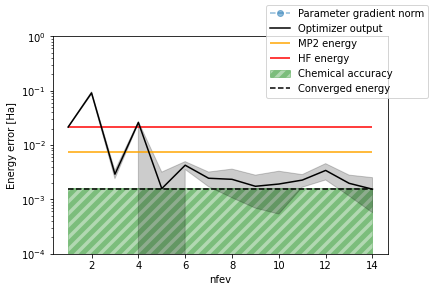

In [363]:
from matplotlib import pyplot as plt

plt.rc('hatch', color='k', linewidth=5)
fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y_stddev = zip(*interim_values['stddev'])
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
#axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
#axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
#axis.hlines(-0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.fill_between(X, -0.0016, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')

Y_error = Y - molecule.fci_energy
axis.plot(X, Y_error, color='black', label='Optimizer output')
axis.hlines(vqe_result['fun'] - molecule.fci_energy, 1, len(X), color='black', label='Converged energy', ls='--')
plt.fill_between(X, Y_error - Y_stddev, Y_error + Y_stddev, alpha=0.2, color='black')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
#axis.set_ylim([np.min(Y_error)*2,(molecule.hf_energy-molecule.fci_energy)*2])
axis.set_ylim([1e-4, 1e-0])
axis.set_yscale('log')

#try:
#    axis_param = axis.twinx()
#    X_grad, Y_grads = zip(*interim_values['gradients'])
#    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
#    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
#    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
#except:
#    pass

fig.legend()
plt.show()

# program metadata

In [114]:
meta = {
    "name": "symmer_vqe",
    "description": "VQE program using symmer",
    "max_execution_time": 100000,
    "spec": {},
}

In [115]:
meta["spec"]["parameters"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "properties": {
        "adapt_flag": {
            "description": "Indicates whether ADAPT-VQE should be performed.",
            "type": "bool",
            "default": "True",
        },
        "adapt_max_cycles": {
            "description": "The maximum number of ADAPT-VQE cycles.",
            "type": "integer",
            "default": "5",
        },
        "adapt_termination_threshold": {
            "description": "ADAPT-VQE will terminate upon achieving this threshold.",
            "type": "float",
            "default": "0.1",
        },
        "ansatz_circuit": {
            "description": "Parametrized Ansatz",
            "type": "QuantumCircuit",
            "default": "None",
        },
        "ansatz_pool": {
            "description": "The operator whose terms shall be taken as the excitation pool for ADAPT-VQE.",
            "type": "PauliSumOp",
            "default": "None",
        },
        "observable_groups": {
            "description": "Decomposition of operator into groups, e.g. qubit-wise commuting",
            "type": "List[Union[PauliSumOp, PauliOp]]",
            "default": "None"
        },
        "observable": {
            "description": "The observable on which we wish to perform eigenvalue estimation",
            "type": "PauliSumOp",
            "default": "None",
        },
        "opt_setting": {
            "description": "Optimizer settings",
            "type": "dict",
            "default": "{'maxiter':10}",
        },
        "init_params": {
            "description": "Initial vector of parameters. This is a numpy array.",
            "type": "array",
            "default": "None",
        },
        "n_shots": {
            "description": "The number of shots used for each circuit evaluation.",
            "type": "integer",
            "default": "2**12",
        },
        "n_realize": {
            "description": "The number of realizations of each energy estimation - these are averaged over.",
            "type": "integer",
            "default": "1",
        },
        "n_groups": {
            "description": "The number of classical shadow groups.",
            "type": "integer",
            "default": "5",
        },
        "mitigate_errors": {
            "description": "Use matrix-free measurement mitigation (mthree), default=False.",
            "type": "boolean",
            "default": "True",
        },
        "reference_energy": {
            "description": "A target energy, such as full-configuration-interaction (FCI) if it is available.",
            "type": "float",
            "default": "None",
        },
        "reference_state": {
            "description": "A single basis state in which to initiate the ansatz circuit.",
            "type": "array",
            "default": "None",
        },
    },
    "required": [],
}

meta["spec"]["return_values"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Tuple of final result in SciPy optimizer format and dictionary of interim values",
    "type": "Tuple[scipy.optimize.optimize.OptimizeResult, Dict]",
}

meta["spec"]["interim_results"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Parameter vector at current optimization step. This is a numpy array.",
    "type": "array",
}